In [1]:
import math
import cv2
import numpy as np
import Tien_xu_ly
import matplotlib.pyplot as plt 

# Định nghĩa các hằng số dùng cho ngưỡng thích nghi


ADAPTIVE_THRESH_BLOCK_SIZE: Đây là kích thước của khu vực lân cận sẽ được sử dụng để tính ngưỡng cục bộ. Trong trường hợp này, kích thước của khu vực là 19x19 pixel.

Ngưỡng cục bộ (adaptive threshold) là một kỹ thuật được sử dụng để chuyển đổi ảnh xám (grayscale) thành ảnh nhị phân (binary image) dựa trên một ngưỡng được tính toán dựa trên các giá trị pixel trong một khu vực lân cận xung quanh từng điểm ảnh

In [2]:

ADAPTIVE_THRESH_BLOCK_SIZE = 19 



ADAPTIVE_THRESH_WEIGHT: Đây là một hệ số được sử dụng trong phương pháp tính toán ngưỡng cục bộ. Nó ảnh hưởng đến mức độ làm mờ và làm sắc nét ảnh kết quả. Trong trường hợp này, giá trị của hệ số là 9.

In [3]:
ADAPTIVE_THRESH_WEIGHT = 9

In [4]:
# Biến đếm số lượng biển số xe
n = 1  

# Định nghĩa các hằng số dùng cho lọc kí tự
Min_char = 0.01
Max_char = 0.09

In [5]:
import cv2
import numpy as np
import math

# Giả sử bạn đã có img, contours, anh_xam và anh_nhi_phan từ trước
def tachanh(url) :
    img = cv2.imread(url)
    img = cv2.resize(img, dsize=(1920, 1080))
    anh_xam, anh_nhi_phan = Tien_xu_ly.tienxuly(img)
    #Trong xử lý ảnh, việc tạo ảnh biên bằng phương pháp Canny (Canny edge detection) giúp phát hiện và nhận dạng các ranh giới hoặc biên của các đối tượng trong ảnh. Điều này có thể hữu ích trong nhiều ứng dụng, bao gồm nhận dạng vật thể, phân loại và phát hiện các đặc điểm quan trọng trong hình ảnh.
    canny_image = cv2.Canny(anh_nhi_phan, 250, 255)  # Tạo ảnh biên bằng phương pháp Canny
    kernel = np.ones((3, 3), np.uint8)  # Tạo kernel cho phép dãn (Tạo ra một kernel có kích thước 3x3 với tất cả các giá trị là 1. Kernel này được sử dụng để xác định cách phép dãn sẽ được áp dụng cho ảnh.)
    dilated_image = cv2.dilate(canny_image, kernel, iterations=1) 
    # Dãn ảnh (Áp dụng phép dãn cho ảnh canny_image bằng cách sử dụng kernel được chỉ định. Tham số iterations=1 xác định số lần lặp của quá trình dãn, trong trường hợp này là một lần.)
    # cv2.imshow("dilated_image",dilated_image)
    contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Sắp xếp và lấy 10 đường viền có diện tích lớn nhất
    screenCnt = []  # Danh sách các đường viền của biển số xe
    for c in contours:
        peri = cv2.arcLength(c, True)  # Tính chu vi của đường viền
        approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Làm xấp xỉ đa giác, chỉ giữ đường viền có 4 cạnh
        [x, y, w, h] = cv2.boundingRect(approx.copy())  # Tạo hình chữ nhật bao quanh đa giác
        
        if len(approx) == 4:  # Nếu đường viền có 4 cạnh
            # Kiểm tra xem các đường chéo gần với 90 độ
            angles = []
            for i in range(4):
                pt1 = tuple(approx[i][0])
                pt2 = tuple(approx[(i + 1) % 4][0])
                pt3 = tuple(approx[(i + 2) % 4][0])
                angle = math.degrees(math.atan2(pt3[1]-pt2[1], pt3[0]-pt2[0]) - math.atan2(pt1[1]-pt2[1], pt1[0]-pt2[0]))
                angle = abs(angle) if angle < 180 else 360 - abs(angle)
                angles.append(angle)

            if all(angle > 70 and angle < 100 for angle in angles):
                screenCnt.append(approx)  # Thêm vào danh sách các đường viền của biển số xe
                cv2.putText(img, str(len(approx.copy())), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)
    if not screenCnt:  # Nếu không có biển số nào được phát hiện
        detected = 0
        print("No plate detected")
    else:
        detected = 1

    if detected == 1:
        for screenCnt in screenCnt:
            cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)  # Khoanh vùng biển số xe
            # cv2.imshow("Contours", img)

            ############## Tìm góc của biển số xe #####################
            (x1, y1) = screenCnt[0, 0]
            (x2, y2) = screenCnt[1, 0]
            (x3, y3) = screenCnt[2, 0]
            (x4, y4) = screenCnt[3, 0]
            array = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
            sorted_array = sorted(array, reverse=True, key=lambda x: x[1])
            (x1, y1) = sorted_array[0]
            (x2, y2) = sorted_array[1]
            doi = abs(y1 - y2)  # Tính độ chênh lệch y
            ke = abs(x1 - x2)  # Tính độ chênh lệch x
            angle = math.atan(doi / ke) * (180.0 / math.pi)  # Tính góc nghiêng của biển số

            ####################################

            ########## Cắt biển số và căn chỉnh đúng góc ################
            mask = np.zeros(anh_xam.shape, np.uint8)  # Tạo mặt nạ đen với kích thước bằng ảnh gốc
            new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1)  # Vẽ đường viền biển số lên mặt nạ
            cv2.imwrite("output/mask.jpg", new_image)

            # Cắt ảnh
            (x, y) = np.where(mask == 255)  # Lấy tọa độ của các pixel nằm trong biển số
          
          
            (topx, topy) = (np.min(x), np.min(y))  # Tọa độ trên cùng của biển số
            (bottomx, bottomy) = (np.max(x), np.max(y))  # Tọa độ dưới cùng của biển số

            roi = img[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh chứa biển số
            imgThresh = anh_nhi_phan[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh ngưỡng chứa biển số
            ptPlateCenter = (bottomx - topx) / 2, (bottomy - topy) / 2  # Tính trung điểm của biển số

            if x1 < x2:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)  # Ma trận xoay với góc âm
            else:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, angle, 1.0)  # Ma trận xoay với góc dương

            roi = cv2.warpAffine(roi, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh biển số
            imgThresh = cv2.warpAffine(imgThresh, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh ngưỡng biển số
            roi = cv2.resize(roi, (0, 0), fx=3, fy=3)  # Phóng to ảnh biển số
            imgThresh = cv2.resize(imgThresh, (0, 0), fx=3, fy=3)  # Phóng to ảnh ngưỡng biển số
            
            # # Hiện ảnh sau mỗi công đoạn
            # cv2.imshow("Cropped Plate", roi)
            # cv2.imshow("Cropped Threshold Plate", imgThresh)
            
            # Lưu lại ảnh 
            cv2.imwrite("output/contours_detected.jpg", img)
            cv2.imwrite("output/cropped_plate.jpg", roi)
            cv2.imwrite("output/cropped_threshold_plate.jpg", imgThresh)
            
            
            kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Tạo kernel hình chữ nhật
            thre_mor = cv2.morphologyEx(imgThresh, cv2.MORPH_DILATE, kerel3)  # Áp dụng phép dãn ảnh
            cont, hier = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh đã dãn

            # cv2.imshow(str(n + 20), thre_mor)  # Hiển thị ảnh đã dãn
            cv2.drawContours(roi, cont, -1, (100, 255, 255), 2)  # Vẽ các đường viền ký tự lên ảnh biển số

            ##################### Lọc các ký tự #################
            char_x_ind = {}  # Tạo dictionary lưu chỉ số của các ký tự
            char_x = []  # Danh sách lưu tọa độ x của các ký tự
            height, width, _ = roi.shape  # Lấy kích thước ảnh biển số
            roiarea = height * width  # Tính diện tích ảnh biển số
            
            
            for ind, cnt in enumerate(cont):

                (x, y, w, h) = cv2.boundingRect(cont[ind])  # Tạo hình chữ nhật bao quanh ký tự
                ratiochar = w / h  # Tính tỷ lệ chiều rộng / chiều cao của ký tự
                char_area = w * h  # Tính diện tích của ký tự
                cv2.putText(roi, str(char_area), (x, y + 20), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)
                cv2.putText(roi, str(ratiochar), (x, y + 20), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)

                if (Min_char * roiarea < char_area < Max_char * roiarea) and (0.1 < ratiochar < 0.7):  # Lọc các ký tự hợp lệ
                    if x in char_x:  # Nếu tọa độ x đã tồn tại, tăng x lên 1 để tránh trùng lặp
                        x = x + 1
                    char_x.append(x)  # Thêm tọa độ x vào danh sách
                    char_x_ind[x] = ind  # Lưu chỉ số của ký tự vào dictionary
                    cv2.putText(roi, str(char_area), (x, y + 20), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)
    return char_x,cont,char_x_ind,angle

    


In [6]:
def chuyen_den_trang(image):
    # Chuyển ảnh màu sang ảnh xám
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Áp dụng ngưỡng nhị phân để tạo ra ảnh đen trắng
    _, black_white_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    # cộng nền trắng 
    #  _, black_white_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)*225
    # 
    
    return black_white_image

In [7]:
def add_padding(image):
    # Xác định chiều cao và chiều rộng của ảnh
    height, width = image.shape[:2]
    # Xác định kích thước mới cho ảnh hình vuông
    target_size = max(height, width)
    # Tạo một ảnh hình vuông với kích thước mới và màu nền trắng
    
    squared_image = np.zeros((target_size, target_size), dtype=np.uint8)
    # Tính toán vị trí để đặt ảnh gốc vào trong ảnh hình vuông mới
    x_offset = (target_size - width) // 2
    y_offset = (target_size - height) // 2
    # Đặt ảnh gốc vào trong ảnh hình vuông mới
    squared_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
    return squared_image

In [8]:
def merge_arrays(a, b):
    result = a.copy()  # Tạo một bản sao của mảng a để không ảnh hưởng đến mảng gốc
    result.extend(b)   # Sử dụng phương thức extend() để ghép mảng b vào mảng a
    return result


đọc ảnh từ theo thứ tự

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_images_from_paths(paths):
    """
    Hiển thị các ảnh từ các đường dẫn trong mảng.

    Args:
    paths (list): Mảng chứa các đường dẫn đến các ảnh.

    Returns:
    None
    """
    num_images = len(paths)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i, path in enumerate(paths):
        if os.path.exists(path):  # Kiểm tra xem tệp có tồn tại không
            img = mpimg.imread(path)
            axs[i].imshow(img,cmap="gray")
            axs[i].axis('off')
        else:
            print(f"Tệp '{path}' không tồn tại.")

    plt.show()

# Mảng chứa các đường dẫn đến các ảnh



# Hiển thị ảnh từ các đường dẫn trong mảng



In [10]:
import os
from matplotlib import pyplot as plt
import shutil


import cv2
def phantachkytu(path):
    a,cont,char_x_ind,gocxoay=tachanh(path)
    b = abs(gocxoay)
    kichthuoc = cv2.imread("output/cropped_threshold_plate.jpg")
    kichthuoc = chuyen_den_trang(kichthuoc)
    height__,weight= kichthuoc.shape
    gocxoay = math.radians(gocxoay)
    height_ = height__- math.sin(gocxoay)*weight
    print(height_)
    
    

    roi = cv2.imread("output/cropped_threshold_plate.jpg")
    # nếu muốn nền trắng : roi = cv2.imread("output/cropped_plate.jpg")


    # Sắp xếp các tọa độ x theo thứ tự tăng dần
    char_x = sorted(a)  
    # Sao chép hình ảnh gốc để vẽ tất cả các hình chữ nhật
    roi_with_rects = roi.copy()

    # Màu sắc mới cho khung hình chữ nhật
    rectangle_color = (255, 0, 0)  # Màu trắng
    # Path to the directory you want to delete
    dir_path = 'chars'

    # Delete the directory and all its contents if it exists
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        
    tenfile1=[]
    tenfile2=[]
    line1=[]
    line2=[]
    for i in char_x:
        (x, y, w, h) = cv2.boundingRect(cont[char_x_ind[i]])  # Tạo hình chữ nhật bao quanh ký tự
        # Vẽ hình chữ nhật bao quanh ký tự với màu mới
        cv2.rectangle(roi_with_rects, (x, y), (x + w, y + h), rectangle_color, 2)  
        char_image = roi[y:y+h, x:x+w]
        if 4.5 > h / w > 1 and h > height_/2.6 and x>1  :
            

            # Create the directory
            os.makedirs(dir_path, exist_ok=True)
            if y < height_/3 :
                i=1
                char_image = chuyen_den_trang(char_image)
                char_image = add_padding(char_image)
                line1.append(char_image)
                
                cv2.imwrite(f'chars/char_dong_{i}_{x}_{y}_{h}_{w}_{height_}_{weight}.png', char_image)  # Save the character image to a file
                g = f'chars/char_dong_{i}_{x}_{y}_{h}_{w}_{height_}_{weight}.png'
                tenfile1.append(g)
            else :
                i=2
                char_image = chuyen_den_trang(char_image)
                char_image = add_padding(char_image)
                line2.append(char_image)
                cv2.imwrite(f'chars/char_dong_{i}_{x}_{y}_{h}_{w}_{height_}_{weight}.png', char_image)
                g = f'chars/char_dong_{i}_{x}_{y}_{h}_{w}_{height_}_{weight}.png'
                tenfile2.append(g)
    
    # Chuyển đổi từ BGR sang RGB để hiển thị bằng Matplotlib
    roi_with_rects_rgb = cv2.cvtColor(roi_with_rects, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_with_rects_rgb,cmap='gray')  # Hiển thị hình ảnh với tất cả các hình chữ nhật
    plt.show()
    return tenfile1,tenfile2,gocxoay,height__,weight,height_,line1,line2

284.68277056312553


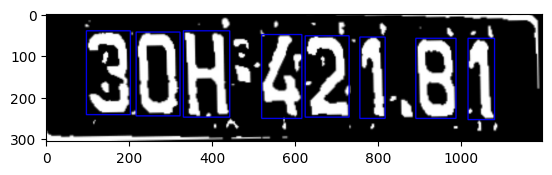

0.017809821564748415
306
1197
284.68277056312553


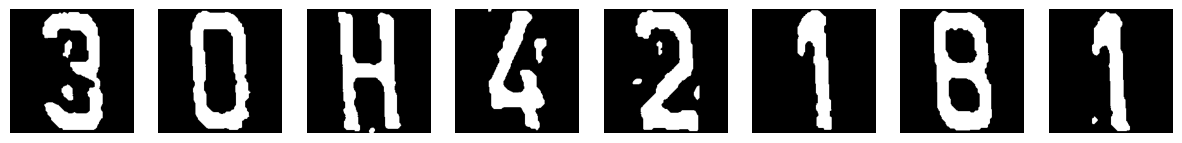

In [11]:
path = "image/58.jpg"
a,b,gocxoay,h,w,he,l1,l2=phantachkytu(path)
m = merge_arrays(a,b)
# print(m)
print(gocxoay)
print(h)
print(w)
print(he)
display_images_from_paths(m)



In [12]:
from tensorflow.keras.models import load_model

# Load the entire model back.
model = load_model('model.keras')

In [13]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the saved model
char_list=l1+l2
# Predicting the output
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char: # iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3) # preparing image for the model
        y_ = model.predict(img)[0] # predicting the class
        class_index = np.argmax(y_) # get the index of the highest probability class
        character = dic[class_index] # map index to character
        output.append(character) # storing the result in a list

    plate_number = ''.join(output)

    return plate_number


print(show_results(char_list))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
34442T4T


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


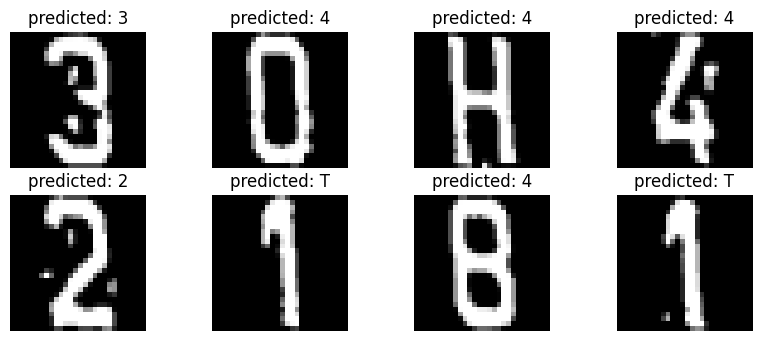

In [14]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Get predicted characters
predicted_characters = show_results(char_list)

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i, ch in enumerate(char_list):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'predicted: {predicted_characters[i]}') # Now predicted_characters is defined
    plt.axis('off')
plt.show()